# Экономический эффект

Теперь время оценить экономическую эффективность модели. В связи с большой несбалансированностью выборки, в зависимости от того, был ли применен oversampling или нет, можно столкнуться с двумя проблемами:
* Если используется несбалансированная выборка, то очень большое число False Negative, и recall на уровне 1 процента.
* Если используется сбалансированная выборка, то очень большое число False Positive (их число может даже превышать число True Negative), и precision на уровне 10 процентов.

Оба варианты не очень хороши, так как если мы не распознаем склонного к оттоку клиента, то, не предпринимая попыток его удержания, мы его потеряем, и прибыль уменьшится. Если же мы считаем, что клиент склонен разорвать контракт, в то время когда он лоялен, то мы тратим впустую деньги на его удержание, и прибыль тоже соответственно уменьшится. Понятно, что потерянный клиент нам обходится дороже, чем удержание лояльного, но вместе с тем клиентов, готовых разорвать контракт, не так уж и много, порядка 7.5 процентов, и если классификатор слишком оптимистичен, то мы будем считать слишком многих клиентов склонными к разрыву контракта и  тратить слишком много на их удержание, и потери от этого могут быть больше, чем считать вообще всех клиентов лояльными. 

Из этого следует, что в данном случае нас интересуют не столько разные метрики качества классификации, сколько их экономический эффект. Измерять его мы будем как разницу между случаем, когда все клиенты считаются лояльными, и результатом классификатора. Для упрощения будем считать, что ежемесячная абонплата одинакова для всех клиентов.

Пусть мы считаем всех клиентов лояльными, и не вообще не занимаемся их удержанием. Допустим, что число склонных к оттоку клиентов в выборке равно $k$, тогда наши потери составляют $L = -kb$ евро, где $b$ - это ежемесячная абонплата. 

Теперь рассмотрим случай с применением классификатора, пусть $r$ - стоимость удержания, $p$ - вероятность того, что клиент, склонный к оттоку, примет наше предложение, $k_1$ - количество False Negative, $l$ - количество False Positive. Тогда наши потери составляют:
$$L_{class} = p(k - k_1)(b - r) - rl - k_1b - (1 - p)(k - k_1)b$$

Очевидно, что наш классификатор имеет экономический смысл, если $L_{class} > L$. Далее для классификатора можно подобрать оптимальную вероятность, начиная с которой мы считаем клиента склонным к оттоку, которая минимизирует наши потери. Но далее мы будем использовать и немного другой вариант оптимизации: рассматривать только клиентов с самой высокой вероятностью оттока (например 5 процентов от всей выборки), и считать экономическую целесообразность для них. Ниже построим оптимальную модель, выбранную на прошлой неделе.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from random import sample
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
le = LabelEncoder()
ohe = OneHotEncoder()
df = pd.read_csv('train_churn.csv', header = 0)
df_test = pd.read_csv('test_churn.csv', header = 0)

def feature_matrix(df, df_test, na_val, max_cat, n_num = 190, na_cat = 'na', label = 'Churn'):
    df_all = pd.concat([df, df_test])
    df_all = df_all.iloc[:,n_num:].dropna(axis = 1, how = 'all').fillna(na_cat)
    cat_columns = df_all.columns
    cat_sorted = df_all.drop(label, axis = 1).describe().iloc[1,:].sort_values()
    
    df_num = df.iloc[:,:n_num].dropna(axis = 1, how = 'all')
    df_test_num = df_test.iloc[:,:n_num].dropna(axis = 1, how = 'all')    
    for feature in df_num.columns:
        df_num['Sq'+feature] = df_num[feature] ** 2
        df_test_num['Sq'+feature] = df_test_num[feature] ** 2
    if na_val in ['mean', 'median', 'most_frequent']:
        imputer = Imputer(strategy = na_val)
        X_num = df_num.values
        X_num = imputer.fit_transform(X_num)
        X_test_num = df_test_num.values
        X_test_num = imputer.transform(X_test_num)
    else:
        X_num = df_num.fillna(na_val).values
        X_test_num = df_test_num.fillna(na_val).values
        
    df_cat = df.iloc[:,n_num:]
    df_cat.fillna(na_cat, inplace = True)
    df_test_cat = df_test.iloc[:,n_num:]
    df_test_cat.fillna(na_cat, inplace = True)
    
    df_part = df_cat[list(cat_sorted[cat_sorted > max_cat].index)]
    df_test_part = df_test_cat[list(cat_sorted[cat_sorted > max_cat].index)]
    for feature in df_part.columns:
        df_part[feature] = df_part[feature].map(df_part.groupby(feature).size()) / len(df_part)
        df_test_part[feature] = df_test_part[feature].map(df_test_part.groupby(feature).size()) / len(df_test_part)
    
    X_part = df_part.values
    X_train = np.concatenate((X_num, X_part), axis = 1)
    y_train = df[label].values
    X_test_part = df_test_part.values
    X_test = np.concatenate((X_test_num, X_test_part), axis = 1)
    y_test = df_test[label].values
    
    if max_cat >= 2:
        df_all = df_all[list(cat_sorted[cat_sorted <= max_cat].index)]
        df_ohe = df_cat[list(cat_sorted[cat_sorted <= max_cat].index)]
        df_test_ohe = df_test_cat[list(cat_sorted[cat_sorted <= max_cat].index)]
        for feature in df_all.columns:
            df_all[feature] = le.fit_transform(df_all[feature].values)
            df_ohe[feature] = le.transform(df_ohe[feature].values)
            df_test_ohe[feature] = le.transform(df_test_ohe[feature].values)
        X_ohe = ohe.fit_transform(df_ohe.values)
        X_test_ohe = ohe.transform(df_test_ohe.values)
        X_train = np.concatenate((X_train, X_ohe.toarray()), axis = 1)
        X_test = np.concatenate((X_test, X_test_ohe.toarray()), axis = 1)
    return(X_train, y_train, X_test, y_test)

In [4]:
df_c = df[df['Churn'] == 1]
np.random.seed(147)
df_3c = shuffle(pd.concat([df, df_c, df_c]))
X_train, y_train, X_test, y_test = feature_matrix(df_3c, df_test, na_val = 'mean', max_cat = 30)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, stratify = y_test, random_state = 147)

In [5]:
gb_class = GradientBoostingClassifier(random_state = 147)
gb_class.fit(X_train, y_train)
model = SelectFromModel(gb_class, prefit = True)
X_train_fm = model.transform(X_train)
print(X_train_fm.shape, X_train.shape)

(36762, 65) (36762, 566)


In [6]:
gb_opt = GradientBoostingClassifier(n_estimators = 147, max_depth = 4, max_features = 'sqrt', random_state = 147)
gb_opt.fit(X_train_fm, y_train)
X_val_fm = model.transform(X_val)
y_pred = gb_opt.predict(X_val_fm)
y_proba = gb_opt.predict_proba(X_val_fm)[:,1]

Тут мы воспроизводим оптимальную модель из прошлой недели, только в данном случае разделяем тестовый сет на два: на одном, валидационном, мы будем подбирать оптимальные параметры модели, на втором, тестовом, давать окончательную оценку модели. 

In [7]:
y_df = pd.DataFrame(y_val, columns = ['Churn'])
y_df['Probability'] = y_proba
y_df = y_df.sort_values('Probability', ascending = False)
y_df['Churn'].value_counts()

-1    3702
 1     298
Name: Churn, dtype: int64

Мы построили датасет из истинной принадлежности класса и вероятность принадлежности к классу отток классификатором, отсортированную по убыванию. Будем считать, что клиент приносит нам доход в 50 евро, если он разрывает контракт, то мы 50 евро теряем. Затраты на удержание равны 10 евро (допустим в целях удержания мы предлагаем ему скидку на абонплату в 10 евро, которую он принимает с вероятностью 0.8), если мы верно распознаем клиента, склонного к разрыву контракта, то мы получаем доход в 40 евро с вероятностью 0.8 и теряем 50 евро с вероятностью 0.2, если вы неверно распознаем клиента, то мы тратим 10 евро на удержание лояльного клиента. Всего в данной валидационной выборке 298 клиентов, склонных к оттоку, если мы не приложим никаких усилий для их удержания, то мы потеряем $298 \times -50 = -14900$ евро. Как было сказано, классификатор будем считать хорошим, если в результате его применения потери составят менее вышеназванной суммы. 

Ниже представлена функция, подсчитывающая выгоду от применения классификатора, мы задаем какой процент от общего числа наблюдений с наибольшей вероятностью оттока мы выбираем (percent), доход от клиента (b), вероятность, что он примет наше предложение (p для клиента склонного к оттоку, 1 для лояльного клиента), стоимость удержания (r) и вероятность, начиная с которой мы считаем клиента склонным к оттоку (one_proba). Меняя параметры one_proba и percent, можно выбрать также менять стратегию: либо мы удерживанием только определенное число клиентов, либо всех клиентов, с вероятностью оттока выше определенного уровня.

In [8]:
def profit_count(df, percent, one_proba = 0.5, b = 50, p = 0.8, r = 10, label = 'Churn', proba = 'Probability'):
    len_top = int(percent * len(df))
    len_one_proba = np.where(df[proba] >= one_proba)[0][-1] + 1
    df_high = df.iloc[:min(len_top, len_one_proba), :]
    df_low = df.iloc[min(len_top, len_one_proba):, :]
    b_offer = np.array(df_high[label].value_counts())[1] * (b - r) * p
    l_offer_fn = np.array(df_high[label].value_counts())[1] * b * (1 - p)
    l_offer_fp = np.array(df_high[label].value_counts())[0] * r 
    l_notpred = np.array(df_low[label].value_counts())[1] * b 
    loss = b_offer - l_offer_fn - l_offer_fp - l_notpred
    total_loss = -np.array(df[label].value_counts())[1] * b
    return(loss - total_loss)

In [65]:
print(profit_count(y_df, 0.01, one_proba = 0.06), 
      profit_count(y_df, 0.25, one_proba = 0.06), 
      profit_count(y_df, 0.99, one_proba = 0.50))

584.0 824.0 800.0


1) Мы протестировали три подхода:
* удержание 1% клиентов с самой высокой вероятностью оттока
* удержание 25% клиентов с самой высокой вероятность оттока
* удержание клиентов с вероятностью оттока более 50%

Мы видим, что больше всего нам позволяет выиграть удержание 25% клиентов. Ниже мы найдем, какой топ клиентов и какая вероятность оптимальны.

In [9]:
percents = np.arange(0.01, 0.51, 0.01)
benefits = []
for percent in percents:
    benefits.append(profit_count(y_df, percent, one_proba = 0.06))
print(max(benefits), percents[np.argmax(benefits)])

1638.0 0.07


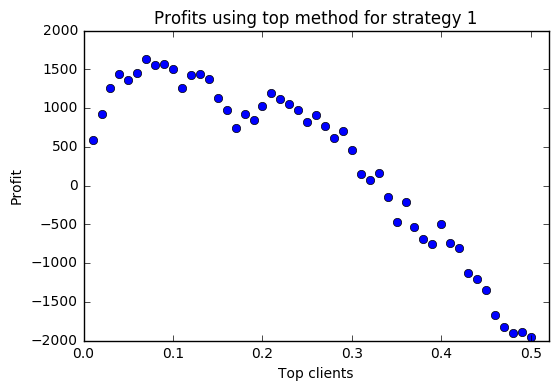

In [10]:
plt.plot(percents, benefits, 'o')
plt.xlabel('Top clients')
plt.ylabel('Profit')
plt.xlim(0, 0.52)
#plt.ylim(0.929, 0.93)
plt.title('Profits using top method for strategy 1')
plt.show()

In [11]:
probas = np.arange(0.35, 0.86, 0.01)
benefits = []
for proba in probas:
    benefits.append(profit_count(y_df, percent = 0.99, one_proba = proba))
print(max(benefits), probas[np.argmax(benefits)])

1670.0 0.67


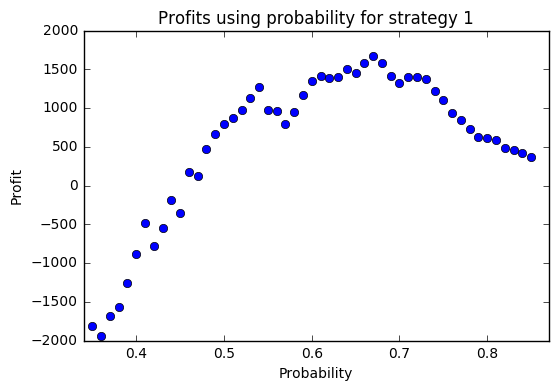

In [12]:
plt.plot(probas, benefits, 'o')
plt.xlabel('Probability')
plt.ylabel('Profit')
plt.xlim(0.34, 0.87)
#plt.ylim(0.929, 0.93)
plt.title('Profits using probability for strategy 1')
plt.show()

2) Мы проверили, какой топ и какую вероятность лучше использовать. Как видно выше, максимизирует прибыль удержание 67% наиболее склонных к оттоку клиентов. На валидационной выборке нам это позволило сэкономить почти 1670 евро.

3) Усложим немного нашу модель, допустим, что мы предлагаем клиенту, которого посчитали склонным к оттоку, не одно предложение для удержания, а два:
* прежнее, скидка 10 евро (r1) в месяц, вероятность, что клиент пример это предложение 0.7 (p1)
* новое, дополнительные услуги за ту же плату, например бесплатные звонки в другие страны или увеличенное число гигабайт интернет трафика. При этом стоимость удержания меньше, например 5 евро (r2). Вероятность, что это предложение примет клиент, склонный к оттоку, равна 0.1 (p2), а лояльный клиент 0.3 (1-p1)

При этом клиент может выбрать только одно предложение из двух. Ниже представлена функция, подсчитывающая экономию в данном случае и подобраны оптимальные варианты топа и минимальной вероятности.

In [13]:
def profit_count2(df, percent, one_proba = 0.5, b = 50, p1 = 0.7, p2 = 0.1, r1 = 10, r2 = 5, 
                  label = 'Churn', proba = 'Probability'):
    len_top = int(percent * len(df))
    len_one_proba = np.where(df[proba] >= one_proba)[0][-1] + 1
    df_high = df.iloc[:min(len_top, len_one_proba), :]
    df_low = df.iloc[min(len_top, len_one_proba):, :]
    b_offer1 = np.array(df_high[label].value_counts())[1] * (b - r1) * p1
    b_offer2 = np.array(df_high[label].value_counts())[1] * (b - r2) * p2
    l_offer_fn = np.array(df_high[label].value_counts())[1] * b * (1 - p1 - p2)
    l_offer1_fp = np.array(df_high[label].value_counts())[0] * r1 * p1
    l_offer2_fp = np.array(df_high[label].value_counts())[0] * r2 * (1-p1)
    l_notpred = np.array(df_low[label].value_counts())[1] * b
    loss = b_offer1 + b_offer2 - l_offer_fn - l_offer1_fp  - l_offer2_fp - l_notpred
    total_loss = -np.array(df[label].value_counts())[1] * b
    return(loss - total_loss)

In [56]:
print(profit_count2(y_df, 0.01, one_proba = 0.06), 
      profit_count2(y_df, 0.25, one_proba = 0.06), 
      profit_count2(y_df, 0.99, one_proba = 0.50))

632.0 2192.0 2262.0


Видим, что данный подход позволил нам больше сэкономить, чем просто скидка на абонплату. При этом в отличие от предыдущего случая, оптимальным является выбор всех клиентов с вероятностью оттока более 50%. Посчитаем теперь оптимальный топ и вероятность. 

In [14]:
percents = np.arange(0.01, 0.51, 0.01)
benefits = []
for percent in percents:
    benefits.append(profit_count2(y_df, percent, one_proba = 0.06))
print(max(benefits), percents[np.argmax(benefits)])

2338.0 0.26


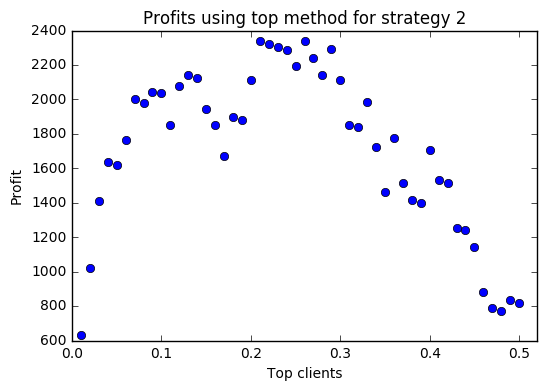

In [15]:
plt.plot(percents, benefits, 'o')
plt.xlabel('Top clients')
plt.ylabel('Profit')
plt.xlim(0, 0.52)
#plt.ylim(0.929, 0.93)
plt.title('Profits using top method for strategy 2')
plt.show()

In [16]:
probas = np.arange(0.35, 0.86, 0.01)
benefits = []
for proba in probas:
    benefits.append(profit_count2(y_df, percent = 0.99, one_proba = proba))
print(max(benefits), probas[np.argmax(benefits)])

2405.0 0.54


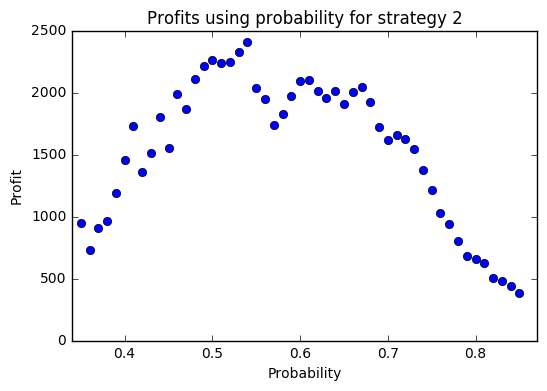

In [17]:
plt.plot(probas, benefits, 'o')
plt.xlabel('Probability')
plt.ylabel('Profit')
plt.xlim(0.34, 0.87)
#plt.ylim(0.929, 0.93)
plt.title('Profits using probability for strategy 2')
plt.show()

In [85]:
y_df_test = pd.DataFrame(y_test, columns = ['Churn'])
y_df_test['Probability'] = gb_opt.predict_proba(model.transform(X_test))[:,1] 
y_df_test = y_df_test.sort_values('Probability', ascending = False)
print(profit_count2(y_df_test, percent = 0.99, one_proba = 0.54))

2388.0


Оптимально использовать всех клиентов, с вероятностью оттока 54%. При этом, экономия на тестовой выборке составляет 2388 евро, всего лишь немногим меньше чем на валидационной.

Примечание: в следующих вопросах для простоты мы будем рассматривать первую модель, как более наглядную. 

4) Применение модели не всегда экономически оправдано. Очевидно, что если мы зададим слишком большой топ или слишком маленькую вероятность, то большое число False Positive нивелирует полноту предсказаний склонных к оттоку клиентов. Также высокая стоимость удержания и/или низкая вероятность принятия нашего предложения склонным к оттоку клиентом снижает экономическую целесообразность модели. 

In [52]:
print(profit_count(y_df, 0.1, b = 40, p = 0.5, r = 15))

-2817.5


Мы видим, что выбрав 10% наиболее склонных к оттоку клиентов, и положив прибыль равной 40 евро, стоимость удержания 15 евро и вероятность принятия предложения 50%, мы остаемся в убытке и использование модели нецелесообразно.

5) Рассмотрим в качестве метрики Recall. Если мы верно классифицируем клиента, склонного к оттоку, то мы вместо потери 50 евро зарабатываем на нем $40 \times 0.8 = 32$, то есть верная классификация такого клиента стоит 82 евро. В нашей валидационной выборке примерно 3700 лояльных клиентов и 300 склонных к оттоку. Таким образом увеличение Recall на один процент соответствует росту прибыли на $300 \times 0.01 \times 90 \times 0.8 = 216$ евро. В свою очередь увеление Recall на три процента соответствуют росту прибыли на 648 евро. В общем случае влияние на прибыль изменения Recall на $\Delta$ считается по формуле:
$$\Delta_{recall} = k \times \Delta \times p \times (2b - r) $$

Примечание: в данном случае мы считаем, что изменяем только Recall, количество же True Negative и False Positive остается неизменным. Это важно, так как несложно посчитать, что увеличение True Negative на один процент об общего числа позволяет сэкономить больше при данных параметрах (а если быть точным то $3700 * 0.01 * 10 = 370$).

6) Вложение средств в улучшение качества модели является экономически оправданным. Как было сказано выше для валидационного датасета, отнесение всех клиентов к лояльным приносит убытки в 14900 евро. В тоже время, при идеальном классификаторе, разница составит $14900 + 298 \times 40 \times 0.8 - 298 \times 50 \times 0.2 = 21456$ евро. Экономия от использования текущей модели 2388 евро, почти в 9 раз меньше. Естественно построение такой модели нереально, данные слишком разреженные и сильно несбалансированные. Но учитывая, что реальная абонентская база Orange составляет порядка 40 миллионов абонентов, то получаем, что улучшение модели на 100 евро на нашем тестовом датасете в 4000 наблюдений соответствует ежемесячной экономии 1 миллиона евро на всей абонентской базе. Немного упрощенно конечно, но наглядно, что даже небольшое улучшение соответствует немалой экономии. 